In [29]:
from sklearn.datasets import fetch_openml
import arff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Loading Data

In [30]:
# Load MNIST dataset via sklearn
# This is a direct download from the internet, given by the book
# X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# One can use np.array_equal to show that the data obtained in this way is the same as that obtained via arff module, see following

In [31]:
# Load data through arff module
# Load the arff file
with open('./data/mnist_784.arff', 'r') as f:
    data = arff.load(f)
    
# Extract the features and labels
X_list = []
y_list = []
for row in data['data']:
    X_list.append(row[:-1])
    y_list.append(row[-1])

In [32]:
# Convert to numpy array
X = np.array(X_list)

In [33]:
# X contains 784 columns (features), which is 28*28
# Each element is a grayscale intensity value
X.shape

(70000, 784)

In [34]:
# Convert to numpy array
# The original class labels in y are strings
y = np.array(y_list).astype(int)

In [35]:
y.shape

(70000,)

In [36]:
# Rescale pixel values to [-1,1], originally [0,255]
# This is for the convergence of training
# Note that this is not the feature-wise normalization done by sklearn.StandardScaler
X = (X/255.0 - 0.5) * 2

[]

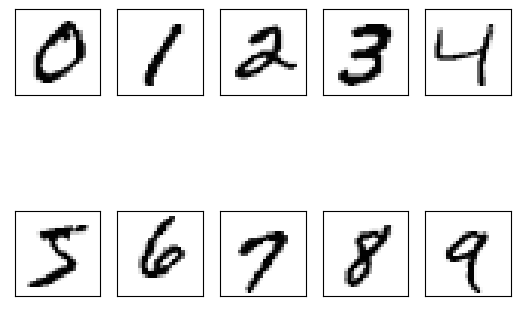

In [37]:
# Visualization of the images
# Show sample images of all ten digits
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
# ax is a 2-by-5 array. To iterate over it, we flatten it.
ax = ax.flatten()
for i in range(10):
    # Select the first image corresponding to a hand-written digit
    img = X[y==i][0].reshape(28, 28)
    # Plot the image
    # Here the colormap must be 'Greys' in order to correctly reflect the values stored in X
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])

[]

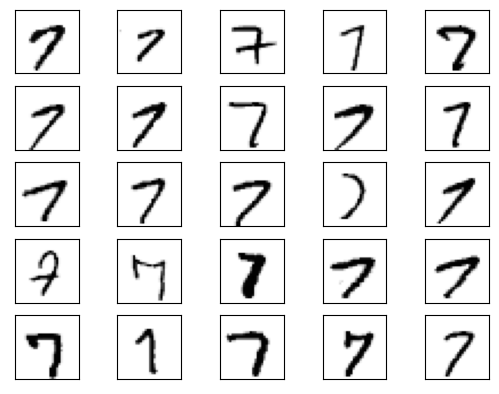

In [38]:
# Show samples of the same digit
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    # Select the first 25 images corresponding to the hand-written digit '7'
    img = X[y==7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])

In [39]:
# Split data
# First split the text data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)
# Then split the training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

## Implementing a Fully-Connected Neural Network

In [40]:
# Helper functions
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# One-hot encoding
def int_to_onehot(y, num_labels): 
    # y stores all class labels. Its shape is (number of examples,)
    # y_onehot stores the one-hot labels
    # Each row corresponds to an example
    y_onehot = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        y_onehot[i, val] = 1
    return y_onehot

In [56]:
# Neural network class
class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        
        # Call the instructor of the parent class
        # The super() function returns a temporary object of the superclass, which allows you to call its methods.
        # ??? What is exactly being excecuted? Why do we need to call the parent class's constructor?
        super().__init__()
        
        # num_features: number of entries in the input vector
        # num_hidden: number of nodes in the hidden layer (only one hidden layer)
        # num_classes: number of classes (== number of nodes in the output layer)
        # Three layers in total: input-->hidden-->output
        # Two weight matrices and bias vectors
        
        
        self.num_classes = num_classes
        
        # Random number generator, used to generate random weights
        rng = np.random.RandomState(random_seed)
        
        # Weight matrix from the input layer to the hidden layer
        # Imagine that the input vector and the output for the hidden layer are column vectors
        # a = W.x + b
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        # bias vector for the hidden layer, 1D array
        self.bias_h = np.zeros(num_hidden)
        # Weight matrix from the hidden layer to the output layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        # bias vector for the output layer, 1D array
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, X):
        # Forward propagation
        # The goal is to calculate outputs for all nodes in the hidden layer and the output layer
        # The net inputs for each layer are also calculated, but not stored. 
        # The output is a vector of class probabilities
        
        # Calculate the net input for the hidden layer: Z = X . W.T + b
        # Note that each row of X is a training example
        # On the other hand, when defining the weight matrix, both its input and output are column vectors.
        # To make each row of the net input matrix the net input of an example, we transpose the weight matrix
        # After multiplying each row of X with the tranposed weight matrix, we should add the bias vector to the result.
        # This is automatically done by numpy's broadcasting rule.
        Z_h = np.dot(X, self.weight_h.T) + self.bias_h
        
        
        # Calculate the output with the sigmoid activating function
        # Note that in the def of sigmoid, np.exp is used. Therefore, this function is already vectorized and can take vector input
        A_h = sigmoid(Z_h)
        
        Z_out = np.dot(A_h, self.weight_out.T) + self.bias_out
        A_out = sigmoid(Z_out)
        
        return A_h, A_out
    
    def backward(self, X, Ah, Aout, y):
        
        # Number of examples
        N = y.shape[0] 
        
        # One-hot encoding
        # Each row is the one-hot label for an example
        # Only one entry in each row is 1, the rest are all zeros
        Y_onehot = int_to_onehot(y, self.num_classes)
        
        # Output layer
        
        # partial L partial Aout
        pL_pAout = (Aout - Y_onehot) / N
        
        # Elementwise derivative
        dAout_dZout = Aout * (1.0 - Aout)
        
        # Temporary array
        B = pL_pAout * dAout_dZout
        
        # partial L partial Wout
        pL_pWout = np.dot(B.T, Ah)
        
        # partial L partial bout
        pL_pbout = np.sum(B, axis=0)
        
        # Hidden layer
        dAh_dZh = Ah * (1-Ah)
        
        # Temporary array
        C = np.dot(B, self.weight_out) * dAh_dZh
        
        # partial L partial Wh
        pL_pWh = np.dot(C.T, X)
        
        # partial L partial bh
        pL_pbh = np.sum(C, axis=0)
        
        # Return all derivatives
        return (pL_pWout, pL_pbout, pL_pWh, pL_pbh)
        
        

In [57]:
model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

## Training the neural network

In [58]:
num_epoch = 50
minibatch_size = 100

def minibatch_genertor(X, y, minibatch_size):
    
    # Number of examples
    N = X.shape[0]
    
    # Index array
    indices = np.arange(N)
    
    # Shuffling the indices
    # This will change the original array, i.e., indices
    np.random.shuffle(indices)
    
    # The starting indices are 0, minibatch_size, 2*minibatch_size, ...
    # The starting index for the last batch is N-minibatch_size
    # To ensure that it is included, we use N-minibatch_size+1
    for idx_start in range(0, N-minibatch_size+1, minibatch_size):
        indices_batch = indices[idx_start:idx_start+minibatch_size]
        yield X[indices_batch], y[indices_batch]
        
    # Note on 'yield': it seems that by using 'yield', the whole function returns a generator
    # This means that if the result is iterated over, X[indices_batch], y[indices_batch] will be generated at each iteration.
    # Thus, these batches are only generated when needed.
    # I am not sure whether the above understanding is correct.

        
    
    

In [59]:
# Test the minibatch generator

# According to the definition of minibatch_genertor, minibatch_gen is a generator
# minibatch_gen returns a batch at each iteration
minibatch_gen = minibatch_genertor(X_train, y_train, minibatch_size)
for X_train_mini, y_train_mini in minibatch_gen:
    print("X batch shape:", X_train_mini.shape, "Y batch shape:", y_train_mini.shape)  



X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape: (100,)
X batch shape: (100, 784) Y batch shape:

In [60]:
# Loss function
def mse_loss(targets, probas, num_labels=10):
    # targets: class labels of several examples
    # probas: predicted class probabilities of the examples
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)

# Accuracy: number of correct predictions / number of all examples
def accuracy(targets, predicted_labels):
    return np.mean(targets == predicted_labels)

In [61]:
# Test mse_loss
Ah, Aout = model.forward(X_valid)
mse = mse_loss(targets=y_valid, probas=Aout)
print(f"Initial validation MSE: {mse}")

Initial validation MSE: 0.27072877992538014


In [62]:
# Test accuracy
# The class with the highest class probability is the predicted class.
predicted_labels = np.argmax(Aout, axis=1)
acc = accuracy(targets=y_valid, predicted_labels=predicted_labels)
print(f"Initial validation accuracy: {acc}")

Initial validation accuracy: 0.0936


In [63]:
# Utilize minibatch to calculate mse and accuracy
# In this way, we only deal with one part of data at a time. This would be helpful if computer memory is limited.
def calc_mse_accuracy_minibatch(model, X, y, num_labels=10, minibatch_size=100):
    mse = 0.0
    num_correct_prediction = 0
    num_example = 0
    minibatch_gen = minibatch_genertor(X, y, minibatch_size=minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        Ah, Aout = model.forward(features)
        predicted_labels = np.argmax(Aout, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - Aout)**2)
        mse += loss
        num_correct_prediction += (predicted_labels==targets).sum()
        num_example += targets.shape[0]
    
    mse /= (i+1)
    acc = num_correct_prediction / num_example
    return mse, acc

In [64]:
mse, acc = calc_mse_accuracy_minibatch(model, X=X_valid, y=y_valid, num_labels=10, minibatch_size=100)
print(f"Initial validation MSE: {mse}")
print(f"Initial validation accuracy: {acc}")

Initial validation MSE: 0.27072877992538014
Initial validation accuracy: 0.0936


In [67]:
# Training the model
def train(model, X_train, y_train, X_valid, y_valid, num_epoch, minibatch_size=100, learning_rate = 0.1):
    # Loss, accuracy on the training set, accuracy on the validation set, at all epochs
    loss_allepoch = []
    acc_train_allepoch = []
    acc_valid_allepoch = []
    
    for e in range(num_epoch):
        # Recall that in the definition of minibatch_genertor, all examples are shuffled.
        # So, for each epoch, different batches are used.
        minibatch_gen = minibatch_genertor(X_train, y_train, minibatch_size)
        for X_train_minibatch, y_train_minibatch in minibatch_gen:
            Ah, Aout = model.forward(X_train_minibatch)
            pL_pWout, pL_pbout, pL_pWh, pL_pbh = model.backward(X_train_minibatch, Ah, Aout, y_train_minibatch)
            
            model.weight_h -= learning_rate * pL_pWh
            model.bias_h -= learning_rate * pL_pbh
            model.weight_out -= learning_rate * pL_pWout
            model.bias_out -= learning_rate * pL_pbout
            
        mse_train, acc_train = calc_mse_accuracy_minibatch(model, X_train, y_train, num_labels=10, minibatch_size=minibatch_size)
        mse_valid, acc_valid = calc_mse_accuracy_minibatch(model, X_valid, y_valid, num_labels=10, minibatch_size=minibatch_size)
        
        acc_train_allepoch.append(acc_train)
        acc_valid_allepoch.append(acc_valid)
        
        # Note that the stored loss is on the training set, while there are two accuracies for the training and validation sets, resepctively.
        loss_allepoch.append(mse_train)
        
        print(f"Epoch {e+1:03d}|{num_epoch:03d} "
              f"MSE Train: {mse_train} "
              f"Accuracy Train: {acc_train} "
              f"Accuracy Valid: {acc_valid}")
        
    return loss_allepoch, acc_train_allepoch, acc_valid_allepoch

In [66]:
# Generate a random seed for shuffling data
np.random.seed(123)
loss_allepoch, acc_train_allepoch, acc_valid_allepoch = train(model, 
                                                              X_train, y_train, X_valid, y_valid, 
                                                              num_epoch=50, minibatch_size=100, 
                                                              learning_rate = 0.1)

Epoch 001|050MSE Train: 0.0724751388657444Accuracy Train: 0.5921272727272727Accuracy Valid: 0.5948
Epoch 002|050MSE Train: 0.04992230615993967Accuracy Train: 0.7677818181818182Accuracy Valid: 0.765
Epoch 003|050MSE Train: 0.037662778170896236Accuracy Train: 0.8260727272727273Accuracy Valid: 0.8252
Epoch 004|050MSE Train: 0.031035519631667046Accuracy Train: 0.8556181818181818Accuracy Valid: 0.853
Epoch 005|050MSE Train: 0.026944329391019487Accuracy Train: 0.8710545454545454Accuracy Valid: 0.8668
Epoch 006|050MSE Train: 0.024216703581149995Accuracy Train: 0.8815272727272727Accuracy Valid: 0.8796
Epoch 007|050MSE Train: 0.02226527713030747Accuracy Train: 0.8888Accuracy Valid: 0.888
Epoch 008|050MSE Train: 0.020786820240023075Accuracy Train: 0.8928363636363637Accuracy Valid: 0.892
Epoch 009|050MSE Train: 0.019653824304735758Accuracy Train: 0.898309090909091Accuracy Valid: 0.8974
Epoch 010|050MSE Train: 0.018714575597759513Accuracy Train: 0.9016909090909091Accuracy Valid: 0.8994
Epoch 011|0

Text(0, 0.5, 'MSE')

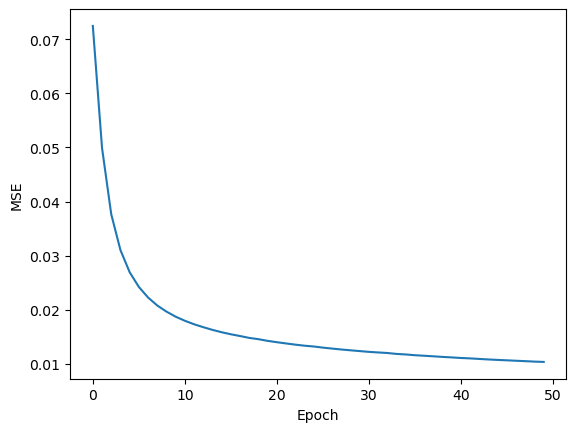

In [68]:
# Plot the MSE on the training set
fig, ax = plt.subplots()
ax.plot(range(len(loss_allepoch)), loss_allepoch)
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")

Text(0, 0.5, 'Accuracy')

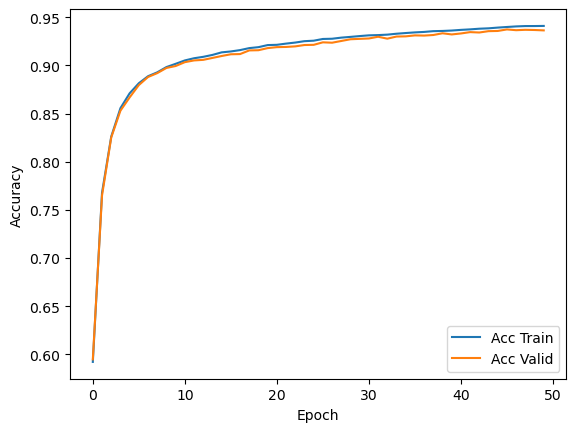

In [69]:
# Plot the accuracy on the training and validation sets
fig, ax = plt.subplots()
ax.plot(range(len(acc_train_allepoch)), acc_train_allepoch, label="Acc Train")
ax.plot(range(len(acc_valid_allepoch)), acc_valid_allepoch, label="Acc Valid")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

In [70]:
# For test data
mse, acc = calc_mse_accuracy_minibatch(model, X=X_test, y=y_test, num_labels=10, minibatch_size=100)
print(f"Test MSE: {mse}")
print(f"Test accuracy: {acc}")

Test MSE: 0.011190514796394734
Test accuracy: 0.9324


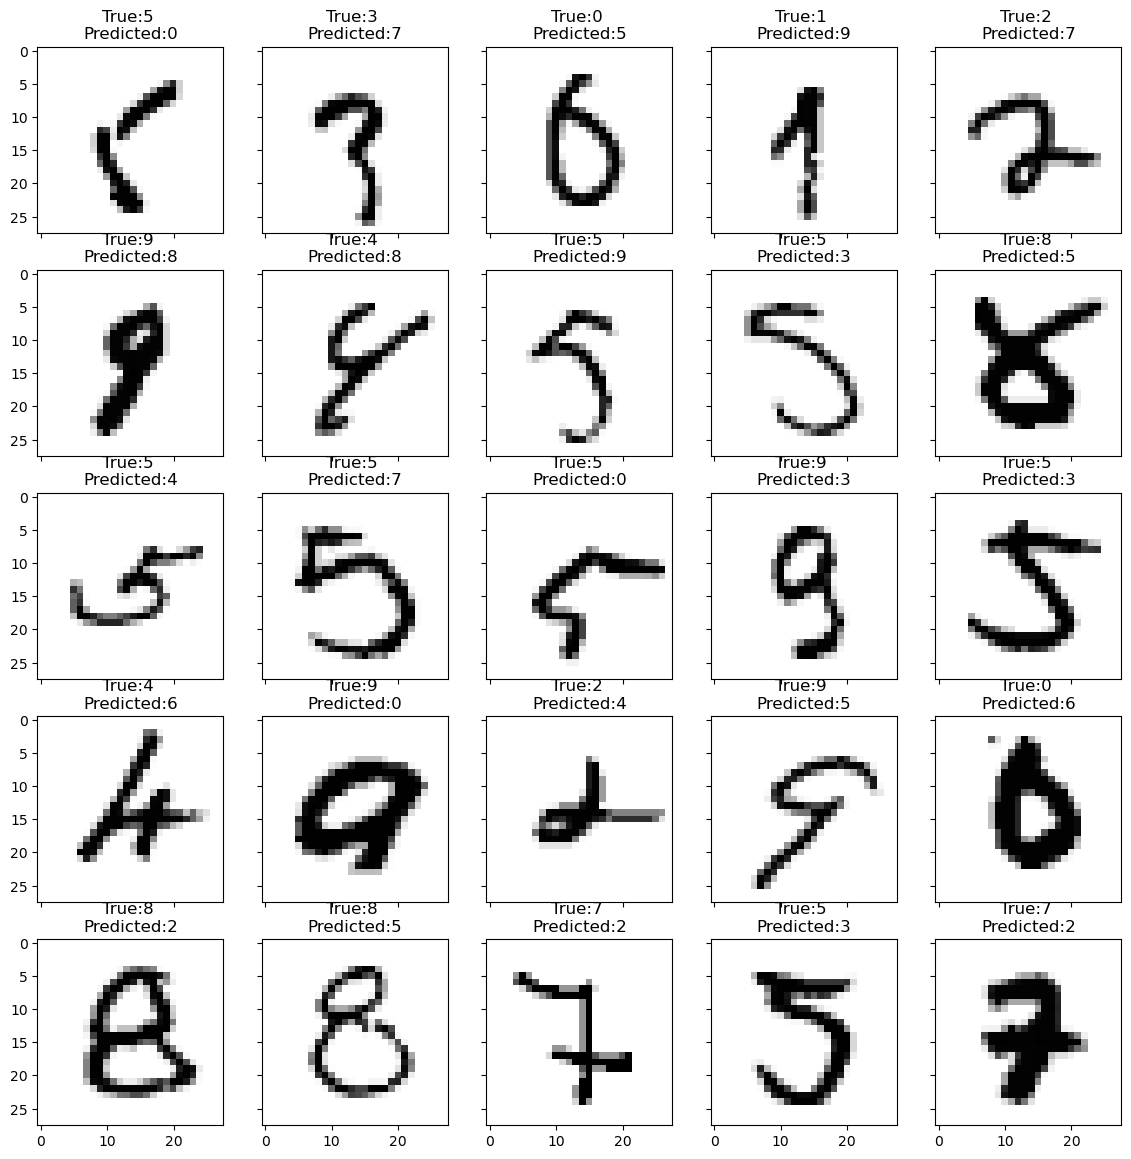

In [72]:
# Visualization of misclassified images in the test data set
Ah, Aout = model.forward(X_test)
predicted_labels = np.argmax(Aout, axis=1)
# Get the first 25 misclassified images
misclassified_images = X_test[predicted_labels!=y_test][:25]
misclassified_labels = predicted_labels[predicted_labels!=y_test][:25]
correct_labels = y_test[predicted_labels!=y_test][:25]

fig, axs = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(14,14))
axs = axs.flatten()

for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    #axs[i].imshow(img, cmap='Greys', interpolation='nearest') # It seems no need to interpolate data
    axs[i].imshow(img, cmap='Greys')
    axs[i].set_title(f"True:{correct_labels[i]} \n"+f"Predicted:{misclassified_labels[i]}")
